# Deep Q-Network (DQN)

This is an example of how to use a DQN agent to solve an unknown environment. Code can be found [here](https://github.com/Chrispresso/reinforcement_learning/tree/master/rl_algos). The paper associated with DQN can be found [here](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf).

From the paper, the expected next state action values can be calculated like so:
$$y_{j} =
\begin{cases}
r_{j},  & \text{for terminal $\phi_{j+1}$} \\
r_{j} + \gamma\text{max$_{a^{'}}$}Q(\phi_{j+1},a^{'};\theta),  & \text{for terminal $\phi_{j+1}$}
\end{cases}$$

Where `Q` in this case is the `target` network. I chose `Q` to be the maximum over the `policy` network rather than explicitly having a `target` network. This still acts as a `target` since there is no guarantee that we choose the maximum action-value due to $\epsilon-\text{greedy}$ action selection.

### Imports and Envrionment

A small `sys.path` hack to allow importing from the location of `rl_algos`.

In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
rl_algos_dir = os.path.dirname(parentdir)
sys.path.insert(0,rl_algos_dir)

Import the `DQNAgent` that will be used and print parameters associated with it.

In [2]:
from rl_algos.dqn_agent import DQNAgent, params
print(params)

{'replay_buffer_size': 50000, 'batch_size': 64, 'discount': 0.99, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer_kwargs': {}, 'loss_func': <function mse_loss at 0x000001430ABD6620>, 'hidden_layers': [32, 24], 'exploration_type': 'e-greedy', 'tau': 0.9, 'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.98}


In [3]:
import gym
from gym import wrappers
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from collections import deque
import numpy as np
from IPython.display import HTML
import os
%matplotlib inline

In [4]:
env = gym.make('CartPole-v0')

In [5]:
states = env.observation_space.shape[0]
actions = env.action_space.n
print(f'States: {states}, Actions: {actions}')

States: 4, Actions: 2


### Train DQN Agent

In [6]:
def train_dqn(env, params, monitor=False, save_vid_every_n_episodes=50, max_episodes=2000, state_dict=None):
    """
    Args:
        params (dict): If this is set, load the agent with these params.
        env (gym.core.Env): The environment to train on
        monitor (Optional[bool, False]): Whether or not to monitor the environment and save a video
        save_vid_every_n_episodes (Optional[int, 50]): Only matters if monitor=True. This is the frequency at which to save videos.
        max_episodes (Optional[int, 2000]): Max number of episodes to try to solve an environment before giving up.
        state_dict (Optional[dict, None]): If this is set, the agent loads a state_dict, i.e. the parameters of the neural network. Mainly used if you want to load an agent later and save a video of best performance.
    """
    agent = DQNAgent(states, actions, params)
    scores = []
    scores_window = deque(maxlen=100)
    eps = params['eps_start']
    if monitor:
        env = wrappers.Monitor(env, 
                               directory='./monitors', 
                               video_callable=lambda episode_id: episode_id % save_vid_every_n_episodes == 0,
                               force=True)
    if state_dict:
        agent.policy_network.load_state_dict(state_dict)
    for episode in range(max_episodes):
        state = env.reset()
        score = 0.0
        for t in range(1000):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(params['eps_end'], eps*params['eps_decay'])
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode+1, np.mean(scores_window)), end="")
        if episode % 100 == 0 and episode > 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        if np.mean(scores_window)>=195.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(max(episode-100+1, 1), np.mean(scores_window)))
            break
    
    return scores, agent

In [7]:
scores, agent = train_dqn(env, params=params)

Episode 100	Average Score: 126.66
Episode 145	Average Score: 196.07
Environment solved in 45 episodes!	Average Score: 196.07


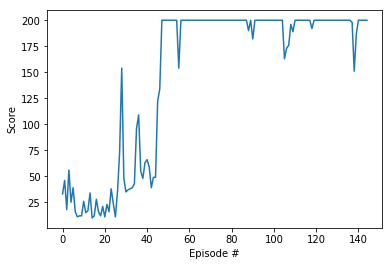

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Now that we have the agent we can save the network parameters.

In [9]:
torch.save(agent.policy_network.state_dict(), 'policy_network.pt')

We can load the parameters and run just one episode with the best parameters for the Q-network. This allows us to see how the agent performs at the end.

In [10]:
agent.params['eps_start'] = agent.params['eps_end']
train_dqn(env, agent.params, monitor=True, save_vid_every_n_episodes=1, max_episodes=1, state_dict=torch.load('policy_network.pt'))

Episode 1	Average Score: 200.00
Environment solved in 1 episodes!	Average Score: 200.00


([200.0], <rl_algos.dqn_agent.DQNAgent at 0x1430e10dd30>)

Now we can play the video to see how it performed at the end. Results will vary since the network is not guaranteed to be the same each time.

In [11]:
video_file = [f for f in os.listdir('./monitors') if 'video000000.mp4' in f]
assert len(video_file) == 1, 'Expected one file. Skip this cell and force load a specific file'
video_file = video_file[0]

In [12]:
video_file = video_file
path = f'./monitors/{video_file}'
HTML(f"""
<video width="640" height="480" controls>
  <source src="{path}" type="video/mp4">
</video>
""")